Для выполнения задания возьмем данные о следующих компаниях: Сбер, Газпром, Лукойл, Роснефть, Норникель

In [53]:
from moexalgo import Ticker
from datetime import datetime, timedelta
import pandas as pd

end_date = datetime.today()
start_date = end_date - timedelta(days=180)

tickers = ['SBER', 'GAZP', 'LKOH', 'GMKN', 'ROSN']
dfs = []

for ticker in tickers:
    t = Ticker(ticker)
    try:
        df = t.candles(start=start_date, end=end_date, period=24) # Информация за каждый день
        df = df[['begin', 'close']].rename(columns={'close': ticker})
        df.set_index('begin', inplace=True)
        dfs.append(df)
    except Exception as e:
        print(f"Ошибка при загрузке {ticker}: {e}")

data = pd.concat(dfs, axis=1)
data = data.dropna()
data.index = pd.to_datetime(data.index)

print(data.head())

              SBER    GAZP    LKOH    GMKN    ROSN
begin                                             
2024-11-12  255.77  135.16  6990.0  113.50  482.05
2024-11-13  254.70  132.60  6925.0  112.98  480.35
2024-11-14  249.52  131.61  6932.5  111.68  473.30
2024-11-15  253.43  133.37  7021.0  115.16  480.10
2024-11-18  248.72  129.12  6955.5  114.46  471.95


Начнём реализовывать Mean-Variance Portfolio

In [64]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

n = len(tickers)
w = cp.Variable(n)
risk = cp.quad_form(w, cov_matrix.values)
ret = mean_returns.values @ w

# Условие: минимизировать риск при полной инвестиции и без шорта
problem = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1, w >= 0])
problem.solve()

weights = w.value
print("Оптимальные веса:")
for t, wt in zip(tickers, weights):
    print(f"{t}: {wt:.4f}")

Оптимальные веса:
SBER: 0.1290
GAZP: 0.0000
LKOH: 0.8072
GMKN: 0.0000
ROSN: 0.0638


Основной вес в портфеле — у Лукойла (LKOH): высокая эффективность риск/доходность
Нулевые веса у Газпрома и Норникеля говорят о либо высокой корреляции с другими активами, либо низкой доходности на единицу риска

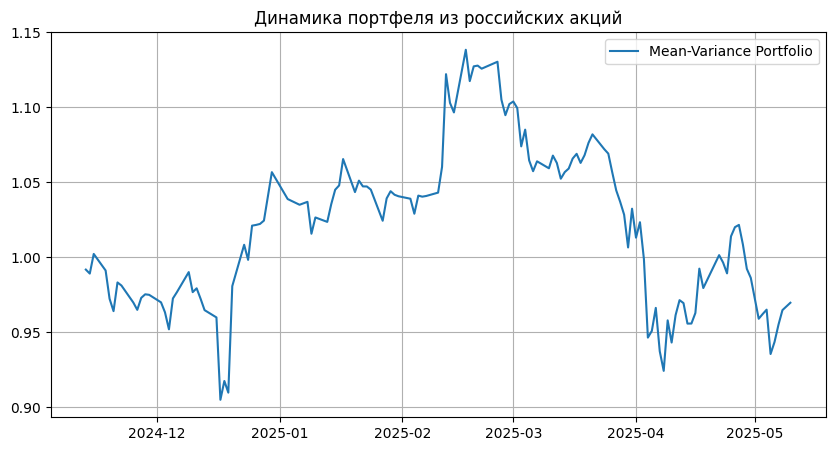

In [65]:
portfolio_returns = returns @ weights
cumulative = (1 + portfolio_returns).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(cumulative, label='Mean-Variance Portfolio')
plt.title('Динамика портфеля из российских акций')
plt.grid()
plt.legend()
plt.show()

После реализации и визуализации модели можно перейти к оценке полученных результатов.

График позволяет наглядно оценить стабильность и тренд. Наш график показывает, как изменилась бы стоимость единицы вложенного капитала в выбранные акции российского рынка, если бы инвестирование происходило согласно рассчитанным оптимальным весам с ежедневным реинвестированием дохода.

С начала 2025 года наблюдается тренд роста, однако с марта начался спад.

Также можно заметить довольно высокую волатильность из-за множества резких скачков.

Поскольку большую часть активов составляют акции компании «Лукойл», динамика портфеля близка к тренду этих бумаг, но с корректировками за счёт «Сбера» и «Роснефти»